# Lecture 8.1: Introduction to Convolutional Neural Networks

## Chapter Outline
<hr>

<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-Learning-Objectives" data-toc-modified-id="Chapter-Learning-Objectives-2">Chapter Learning Objectives</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li><li><span><a href="#1.-Convolutional-Neural-Networks-(CNNs)" data-toc-modified-id="1.-Convolutional-Neural-Networks-(CNNs)-4">1. Convolutional Neural Networks (CNNs)</a></span></li><li><span><a href="#2.-Cooking-up-a-CNN" data-toc-modified-id="2.-Cooking-up-a-CNN-5">2. Cooking up a CNN</a></span></li><li><span><a href="#3.-The-CNN-Recipe-Book" data-toc-modified-id="3.-The-CNN-Recipe-Book-6">3. The CNN Recipe Book</a></span></li><li><span><a href="#4.-CNN-vs-Fully-Connected-NN" data-toc-modified-id="4.-CNN-vs-Fully-Connected-NN-7">4. CNN vs Fully Connected NN</a></span></li></ul></div>

## Chapter Learning Objectives
<hr>

- Describe the terms convolution, kernel/filter, pooling, and flattening
- Explain how convolutional neural networks (CNNs) work
- Calculate the number of parameters in a given CNN architecture
- Create a CNN in `PyTorch`
- Discuss the key differences between CNNs and fully connected NNs

## Imports
<hr>

In [1]:
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'axes.grid': False})

In [2]:
def plot_conv(image, filter):
    """Plot convs with matplotlib."""
    d = filter.shape[-1]
    conv = torch.nn.Conv2d(1, 1, kernel_size=(d, d), padding=1)
    with torch.no_grad():
        conv.weight[:] = filter
    fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
    ax1.imshow(image, cmap='gray')
    ax1.axis('off')
    ax1.set_title("Original")
    ax2.imshow(conv(image[None, None, :]).detach().squeeze(), cmap='gray')
    ax2.set_title("Filtered")
    ax2.axis('off')
    plt.tight_layout();

def plot_convs(image, conv_layer, axis=False):
    """Plot convs with matplotlib. Sorry for this lazy code :D"""
    filtered_image = conv_layer(image[None, None, :])
    n = filtered_image.shape[1]
    if n == 1:
        fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
        ax1.imshow(image, cmap='gray')
        ax1.set_title("Original")
        ax2.imshow(filtered_image.detach().squeeze(), cmap='gray')
        ax2.set_title("Filter 1")
        ax1.grid(False)
        ax2.grid(False)
        if not axis:
            ax1.axis(False)
            ax2.axis(False)
        plt.tight_layout();
    elif n == 2:
        filtered_image_1 = filtered_image[:,0,:,:]
        filtered_image_2 = filtered_image[:,1,:,:]
        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 4), ncols=3)
        ax1.imshow(image, cmap='gray')
        ax1.set_title("Original")
        ax2.imshow(filtered_image_1.detach().squeeze(), cmap='gray')
        ax2.set_title("Filter 1")
        ax3.imshow(filtered_image_2.detach().squeeze(), cmap='gray')
        ax3.set_title("Filter 2")
        ax1.grid(False)
        ax2.grid(False)
        ax3.grid(False)
        if not axis:
            ax1.axis(False)
            ax2.axis(False)
            ax3.axis(False)
        plt.tight_layout();
    elif n == 3:
        filtered_image_1 = filtered_image[:,0,:,:]
        filtered_image_2 = filtered_image[:,1,:,:]
        filtered_image_3 = filtered_image[:,2,:,:]
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12, 4), ncols=4)
        ax1.imshow(image, cmap='gray')
        ax1.set_title("Original")
        ax2.imshow(filtered_image_1.detach().squeeze(), cmap='gray')
        ax2.set_title("Filter 1")
        ax3.imshow(filtered_image_2.detach().squeeze(), cmap='gray')
        ax3.set_title("Filter 2")
        ax4.imshow(filtered_image_3.detach().squeeze(), cmap='gray')
        ax4.set_title("Filter 3")
        ax1.grid(False)
        ax2.grid(False)
        ax3.grid(False)
        ax4.grid(False)
        if not axis:
            ax1.axis(False)
            ax2.axis(False)
            ax3.axis(False)
            ax4.axis(False)
        plt.tight_layout();

## 1. Convolutional Neural Networks (CNNs)
<hr>

### 1.1. Motivation

We've been dealing with "fully connected neural networks" meaning that every neuron in a given layer is connected to every neuron in the next layer. This has two key implications:
1. It results in a lot of parameters.
2. The order of our features doesn't matter.

Consider the simple image and fully connected network below:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/cnn-1.png)

Every input node is connected to every node in the next layer - is that really necessary? When you look at this image, how do you know that it's Tom?
- You notice the structure in the image (there's a face, shoulders, a smile, etc.)
- You notice how different structures are positioned and related (the face is on top of the shoulders, etc.)
- You probably use the shading (colour) to infer things about the image too but we'll talk more about that later.

The point here is that **the structure of our data (the pixels) is important**. So maybe, we should have each hidden node only look at a small area of the image, like this:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/cnn-2.png)

We have far fewer parameters now because we're acknowledging that pixels that are far apart are probably not all that related and so don't need to be connected. We're seeing that structure is important here, so then why should we need to flatten this image at all? Let's be crazy and not flatten the image, but instead, make our hidden layer a 2D matrix:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/cnn-3.png)

We're almost there!

As it stands, each group of 2 x 2 pixels has 4 unique weights associated with it (one for each pixel), which are being summed up into a single value in the hidden layer. But we don't need the weights to be different for each group, we're looking for **structure**, we don't care if Tom's face is in the top left or the bottom right, we're just looking for a face!

Let's summarise the weights into a weight "filter":

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/cnn-4.png)

- Let's see how the filter works
- We'll display some arbitrary values for our pixels
- The filter "convolves" over each group of pixels, multiplies corresponding elements and sums them up to give the values in the output nodes:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/cnn-5.gif)

As we'll see, we can add as many of these "filters" as we like to make more complex models that can identify more useful things:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/cnn-6.png)

We just made a **convolutional neural network** (CNN). Instead of fully-connected hidden nodes, we have 2D filters that we "convolve" over our input data. This has two key advantages:
1. We have less parameters than a fully connected network.
2. We preserve the useful structure of our data.

### 1.2. Convolutions and Filters

Convolution really just means "to pass over the data". What are we "passing"? Our filters - which are also called **kernels**. Here's another gif like the one we saw earlier:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/conv-1.gif)

>Source: modified after [theano-pymc.readthedocs.io](https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html).

So how does this help us extract structure from the data? Well let's see some examples!

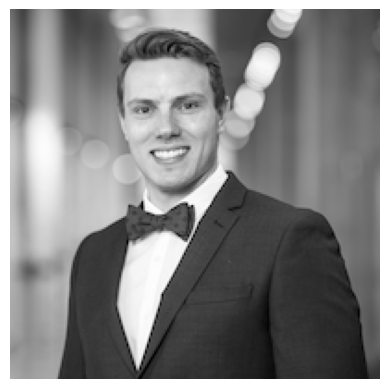

In [4]:
image = torch.from_numpy(plt.imread("tom_bw.png"))
plt.imshow(image, cmap='gray')
plt.axis('off');

We can blur this image by applying a filter with the following weights:

$$\begin{bmatrix} 0.0625 & 0.125 & 0.0625 \\ 0.125 & 0.25 & 0.125 \\ 0.0625 & 0.125 & 0.0625 \end{bmatrix}$$

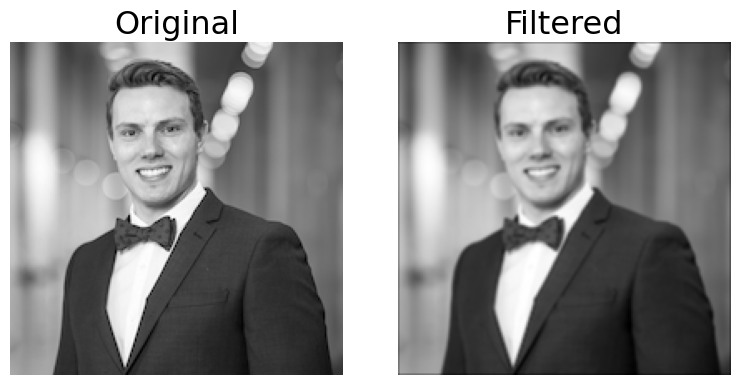

In [5]:
kernel = torch.tensor([[[[ 0.0625,  0.1250,  0.0625],
                         [ 0.1250,  0.2500,  0.1250],
                         [ 0.0625,  0.1250,  0.0625]]]])
plot_conv(image, kernel)

How about this one:

$$\begin{bmatrix} -2 & -1 & 0 \\ -1 & 1 & 1 \\ 0 & 1 & 2 \end{bmatrix}$$

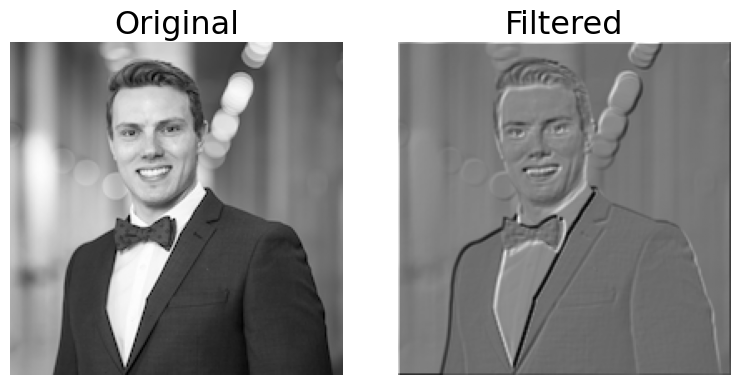

In [6]:
kernel = torch.tensor([[[[ -2,  -1,  0],
                         [ -1,   1,  1],
                         [  0,   1,  2]]]])
plot_conv(image, kernel)

One more:

$$\begin{bmatrix} -1 & -1 & -1 \\ -1 & 8 & -1 \\ -1 & -1 & -1 \end{bmatrix}$$

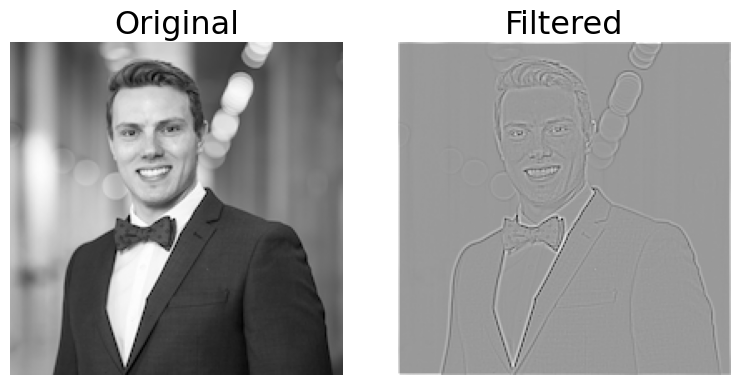

In [7]:
kernel = torch.tensor([[[[  -1,  -1,   -1],
                         [  -1,   8,   -1],
                         [  -1,  -1,   -1]]]])
plot_conv(image, kernel)

[Here's a great website](https://setosa.io/ev/image-kernels/) where you can play around with other filters. We usually use **odd numbers for filters** so that they are applied symmetrically around our input data. Did you notice in the gif earlier that the output from applying our kernel was smaller than the input? Take a look again:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/conv-1.gif)

>Source: modified after [theano-pymc.readthedocs.io](https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html).

By default, our kernels are only applied where the filter fully fits on top of the input. But we can control this behaviour and the size of our output with:
- `padding`: "pads" the outside of the input 0's to allow the kernel to reach the boundary pixels
- `strides`: controls how far the kernel "steps" over pixels.

Below is an example with:
- `padding=1`: we have `1` layer of 0's around our border
- `strides=(2,2)`: our kernel moves 2 data points to the right for each row, then moves 2 data points down to the next row

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/conv-2.gif)

>Source: modified after [theano-pymc.readthedocs.io](https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html).

We'll look more at these below.

## 2. Cooking up a CNN
<hr>

### 2.1. Ingredient 1: Convolutional Layers

We showed some example kernels above. In CNNs the actual values in **the kernels are the weights your network will learn during training**: your network will learn what structures are important for prediction.

In PyTorch, convolutional layers are defined as `torch.nn.Conv2d`, there are 5 important arguments we need to know:
1. `in_channels`: how many features are we passing in. Our features are our colour bands, in greyscale, we have 1 feature, in colour, we have 3 channels.
2. `out_channels`: how many kernels do we want to use. Analogous to the number of hidden nodes in a hidden layer of a fully connected network.
3. `kernel_size`: the size of the kernel. Above we were using 3x3. Common sizes are 3x3, 5x5, 7x7.
4. `stride`: the "step-size" of the kernel.
5. `padding`: the number of pixels we should pad to the outside of the image so we can get edge pixels.

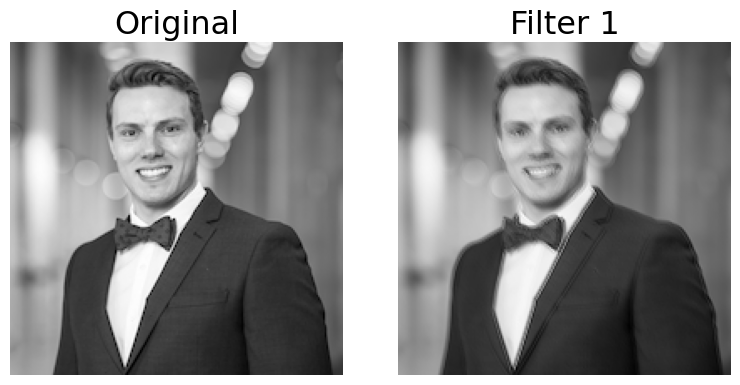

In [8]:
# 1 kernel of (3,3)

conv_layer = torch.nn.Conv2d(1, 1, kernel_size=(3, 3))
plot_convs(image, conv_layer)

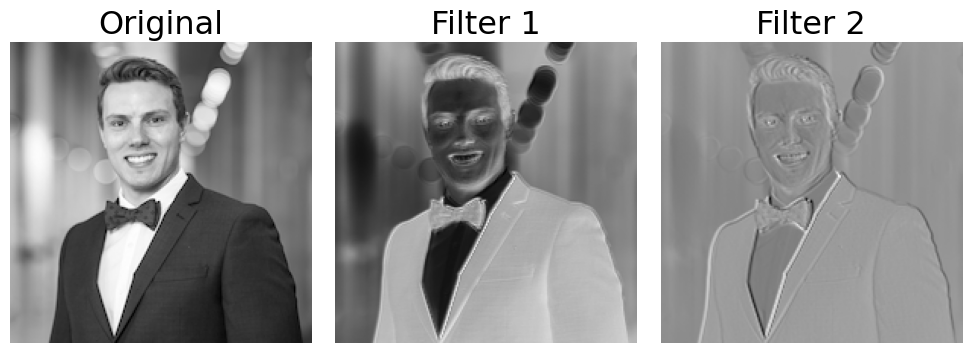

In [10]:
# 2 kernels of (3,3)

# Try to add your conv_layer with kernel_size=(3, 3), input size as 1, output as 2

conv_layer_2 = torch.nn.Conv2d(1,2, kernel_size=(3,3))

plot_convs(image, conv_layer_2)

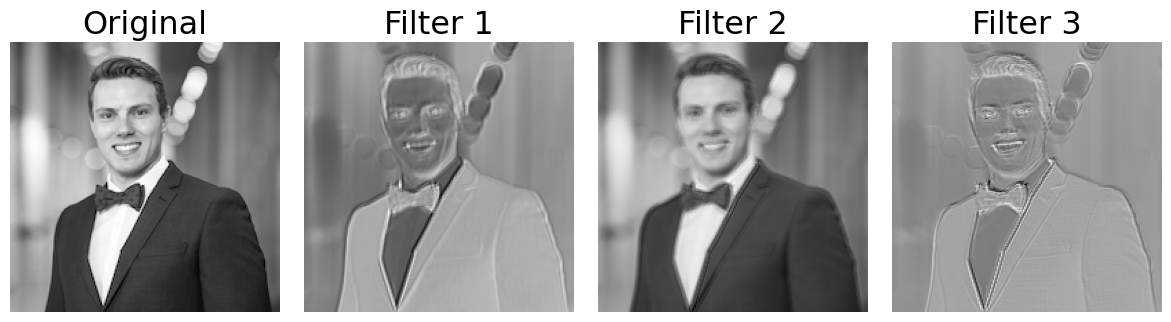

In [11]:
# 3 kernels of (5,5)

# Try to add your conv_layer with kernel_size=(5, 5), input size as 1, output as 3

conv_layer_3= torch.nn.Conv2d(1,3, kernel_size=(5,5))

plot_convs(image, conv_layer_3)

If we use a kernel with no padding, our output image will be smaller as we noted earlier. Let's demonstrate that by using a larger kernel now:

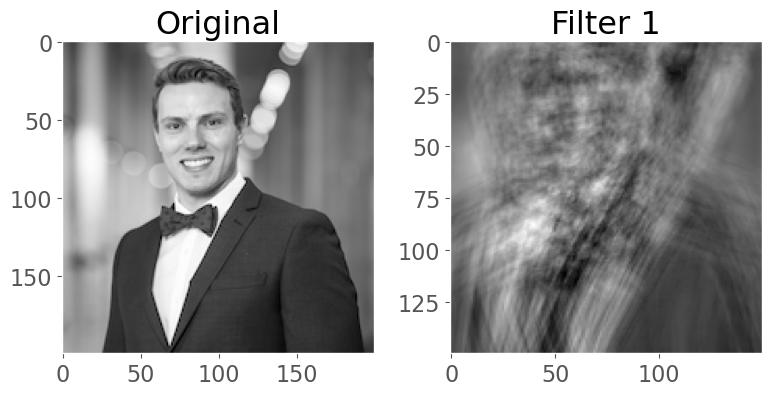

In [12]:
# 1 kernel of (51,51)

# Try to add your conv_layer with kernel_size=(5, 5), input size as 1, output as 1

conv_layer_51= torch.nn.Conv2d(1,1, kernel_size=(51,51))

plot_convs(image, conv_layer_51, axis=True)

As we saw, we can add `padding` to the outside of the image to avoid this:

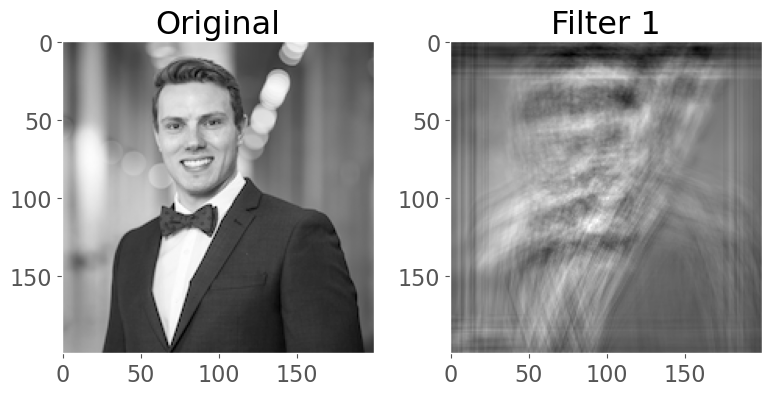

In [13]:
# 1 kernel of (51,51) with padding
conv_layer = torch.nn.Conv2d(1, 1, kernel_size=(51, 51), padding=25)
plot_convs(image, conv_layer, axis=True)

> Setting `padding = kernel_size // 2` will always result in an output the same shape as the input. Think about why this is...

Finally, we also saw before how `strides` influence the size of the output:

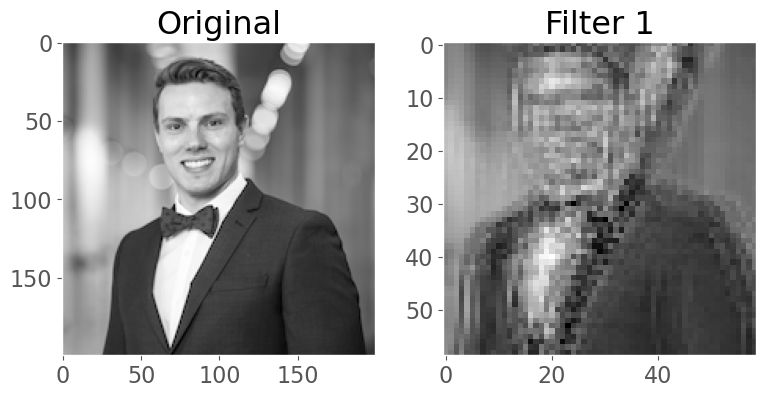

In [14]:
# 1 kernel of (25,25) with stride of 3

# Try to add your conv_layer with kernel_size=(25, 25), input size as 1, output as 1 and stride=3, no padding

conv_layer_s3 = torch.nn.Conv2d(1,1, kernel_size=(25,25), stride=3)
plot_convs(image, conv_layer_s3, axis=True)

With CNN we are no longer flattening our data, so what are our "features"?
Our features are called "channels" in CNN-lingo -> they are like the colour channels in an image:
- A grayscale image has 1 feature/channel
- A coloured image has 3 features/channel
    
![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/channels-1.png)

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/channels-2.png)

What's important with CNNs is that the **size of our input data does not impact how many parameters we have in our convolutonal layers**. For example, your kernels don't care how big your image is (i.e., 28 x 28 or 256 x 256), all that matters is:
1. How many features ("channels") you have: `in_channels`
2. How many filters you use in each layer: `out_channels`
3. How big the filters are: `kernel_size`

Let's see some diagrams:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/cnn-7.png)

For coloured images (3 channels):

![](img/cnn-8.png)

### 2.2. Ingredient 2: Flattening

With our brand new, shiny convolutional layers, we're basically just passing images through the network - cool!

But we're going to eventually want to do some regression or classification. That means that by the end of our network, we are going to need to `torch.nn.Flatten()` our images:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/cnn-9.png)

Let's make that simple CNN above in PyTorch:

In [15]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            #    - in_channels=1: Input has 1 channel (e.g., grayscale images).
            #    - out_channels=3: Outputs 3 feature maps.
            #    - kernel_size=(3, 3): 3x3 convolution filter.
            #    - padding=1: Adds 1 pixel of zero-padding on all sides to preserve spatial dimensions.

            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),  #    - ReLU replaces negative values with 0: f(x) = max(0, x).
            torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(20000, 1) #    - Input size: 20000 (flattened size of the feature maps) 2*100*100.
#    - Output size: 1 (final prediction).
#    - Used for binary classification, producing a single logit output.
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [16]:
model = CNN()
summary(model, (1, 100, 100));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 100, 100]              30
              ReLU-2          [-1, 3, 100, 100]               0
            Conv2d-3          [-1, 2, 100, 100]              56
              ReLU-4          [-1, 2, 100, 100]               0
           Flatten-5                [-1, 20000]               0
            Linear-6                    [-1, 1]          20,001
Total params: 20,087
Trainable params: 20,087
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.92
Params size (MB): 0.08
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


Oh man! 20,000 parameters in that last layer, geez. Is there a way we can reduce this somehow? Glad you asked! See you in the next section.

### Please explain why the size of the above input is (1, 100, 100) and what each parameter represents.

In [24]:
# Your explanation

#Explanation:
#The reason why the input is (1,100,100) since the 1 we have is talking about the channel
#which is a grayscale for the image. For the definition, if we have 3 channels it will have the color for that image
#More than that the 100 is talking about the height of the image
#and the 100 is talking about the width for that
    

### 2.3. Ingredient 3: Pooling

Pooling is how we can reduce the number of parameters we get out of a `torch.nn.Flatten()`. It's pretty simple, we just aggregate the data, usually using the maximum or average of a window of pixels. Here's an example of max pooling:

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/pool.gif)

> Source: modified after [www.oreilly.com/](https://www.oreilly.com/radar/visualizing-convolutional-neural-networks/).

We use "pooling layers" to reduce the shape of our image as it's passing through the network. So when we eventually `torch.nn.Flatten()`, we'll have less features in that flattened layer! We can implement pooling with `torch.nn.MaxPool2d()`. Let's try it out and reduce the number of parameters:

In [17]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Flatten(),
            torch.nn.Linear(1250, 1) #2*25*25
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [18]:
model = CNN()
summary(model, (1, 100, 100));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 100, 100]              30
              ReLU-2          [-1, 3, 100, 100]               0
         MaxPool2d-3            [-1, 3, 50, 50]               0
            Conv2d-4            [-1, 2, 50, 50]              56
              ReLU-5            [-1, 2, 50, 50]               0
         MaxPool2d-6            [-1, 2, 25, 25]               0
           Flatten-7                 [-1, 1250]               0
            Linear-8                    [-1, 1]           1,251
Total params: 1,337
Trainable params: 1,337
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.61
Params size (MB): 0.01
Estimated Total Size (MB): 0.65
----------------------------------------------------------------


We reduced that last layer to 1,251 parameters. Nice job!

## 3. The CNN Recipe Book
<hr>

Here's a CNN diagram of a famous architecture called [AlexNet](https://en.wikipedia.org/wiki/AlexNet) (we'll talk more about "famous architectures" next Chapter):

![](https://raw.githubusercontent.com/Shangyue-CWU/CS457Draft/refs/heads/main/img/alexnet.png)

You actually know what all of the above means now! But, deep learning and CNN architecture remains very much an art. Here is my general recipe book (based on experience, common practice, and popular pre-made architectures - more on those next chapter).

Typical ingredients (in order):
- Convolution layer(s): `torch.nn.Conv2d`
- Activation function: `torch.nn.ReLU`, `torch.nn.Sigmoid`, `torch.nn.Softplus`, etc.
- (optional) Batch normalization: `torch.nn.BatchNorm2d` (more on that next Chapter)
- (optional) Pooling: `torch.nn.MaxPool2d`
- (optional) Drop out: `torch.nn.Dropout`
- Flatten: `torch.nn.Flatten`

## 4. CNN vs Fully Connected NN
<hr>

As an example of the parameter savings introduced when using CNNs with structured data, let's compare the Bitmoji classifier from last chapter, with an equivalent CNN version.

We'll replace all linear layers with convolutional layers with 3 kernels of size (3, 3) and will assume an image size of 128 x 128:

In [19]:
def linear_block(input_size, output_size):
    return torch.nn.Sequential(
        torch.nn.Linear(input_size, output_size),
        torch.nn.ReLU()
    )
class NN(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.main = torch.nn.Sequential(
            linear_block(input_size, 256),
            linear_block(256, 128),
            linear_block(128, 64),
            linear_block(64, 16),
            torch.nn.Linear(16, 1)
        )

    def forward(self, x):
        out = self.main(x)
        return out



In [20]:
model = NN(input_size=128 * 128)
summary(model, (128 * 128,));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]       4,194,560
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 16]           1,040
              ReLU-8                   [-1, 16]               0
            Linear-9                    [-1, 1]              17
Total params: 4,236,769
Trainable params: 4,236,769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.01
Params size (MB): 16.16
Estimated Total Size (MB): 16.23
-------------------------------------

In [21]:

def conv_block(input_channels, output_channels):
    return torch.nn.Sequential(
        torch.nn.Conv2d(input_channels, output_channels, (3, 3), padding=1),
        torch.nn.ReLU()
    )

class CNN(torch.nn.Module):
  def __init__(self, input_channels):
      super().__init__()
      self.main = torch.nn.Sequential(
          conv_block(input_channels, 3),
          conv_block(3, 3),
          conv_block(3, 3),
          conv_block(3, 3),
          conv_block(3, 3),
          torch.nn.Flatten(),
          torch.nn.Linear(49152, 1)
      )

  def forward(self, x):
      out = self.main(x)
      return out

In [22]:
model = CNN(input_channels=1)
summary(model, (1, 128, 128));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]              30
              ReLU-2          [-1, 3, 128, 128]               0
            Conv2d-3          [-1, 3, 128, 128]              84
              ReLU-4          [-1, 3, 128, 128]               0
            Conv2d-5          [-1, 3, 128, 128]              84
              ReLU-6          [-1, 3, 128, 128]               0
            Conv2d-7          [-1, 3, 128, 128]              84
              ReLU-8          [-1, 3, 128, 128]               0
            Conv2d-9          [-1, 3, 128, 128]              84
             ReLU-10          [-1, 3, 128, 128]               0
          Flatten-11                [-1, 49152]               0
           Linear-12                    [-1, 1]          49,153
Total params: 49,519
Trainable params: 49,519
Non-trainable params: 0
---------------------------------